# keras model


## pylibs


In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import cv2
import glob
import pprint
import random
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from keras.models import Model
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from keras.optimizers import SGD, Adam, Adagrad, Adadelta, Nadam
from keras.regularizers import l2
from keras.models import load_model
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from keras import Sequential
from random import randint, choice, shuffle
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, Callback, LearningRateScheduler
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, SeparableConv2D, Input, Concatenate, GlobalAveragePooling2D

## Extra

In [2]:
def print_Color(Input: str, colors: list, print_END: str = '\n', advanced_mode: bool = False) -> None:
    '''
    Prints colored text to the console using advanced terminal colors.

    Args:
        Input (str): The input string to be printed. In advanced mode, '~*' is used to separate different parts of the string to be printed in different colors.
        colors (list): A list of colors for the text. In non-advanced mode, only the first color in the list is used. In advanced mode, each color corresponds to a part of the input string separated by '~*'.
        print_END (str): The string appended after the final output. Default is '\\n'.
        advanced_mode (bool): If True, enables advanced mode that allows multiple colors in one string. Default is False.

    Examples:
    ~~~python
        print_Color('Hello, World!', ['green']) 
        # Prints 'Hello, World!' in green.

        print_Color('~*Hello in green~*Hello in red', ['green', 'red'], advanced_mode=True) 
        # Prints 'Hello in green' in green and 'Hello in red' in red.

    Note:
        The advanced terminal colors can be used by providing the escape sequences directly in the colors list.
        If an invalid color is provided, an error message will be printed.
    '''
    color_code = {
        'black': '\x1b[0;30m',
        'red': '\x1b[0;31m',
        'green': '\x1b[0;32m',
        'yellow': '\x1b[0;33m',
        'blue': '\x1b[0;34m',
        'magenta': '\x1b[0;35m',
        'cyan': '\x1b[0;36m',
        'white': '\x1b[0;37m',
        'normal': '\x1b[0m',
        'bg_black': '\x1b[40m',
        'bg_red': '\x1b[41m',
        'bg_green': '\x1b[42m',
        'bg_yellow': '\x1b[43m',
        'bg_blue': '\x1b[44m',
        'bg_magenta': '\x1b[45m',
        'bg_cyan': '\x1b[46m',
        'bg_white': '\x1b[47m',
        'bg_normal': '\x1b[49m',
        'light_gray': '\x1b[0;90m',
        'light_red': '\x1b[0;91m',
        'light_green': '\x1b[0;92m',
        'light_yellow': '\x1b[0;93m',
        'light_blue': '\x1b[0;94m',
        'light_magenta': '\x1b[0;95m',
        'light_cyan': '\x1b[0;96m',
        'light_white': '\x1b[0;97m',
        'bg_light_gray': '\x1b[0;100m',
        'bg_light_red': '\x1b[0;101m',
        'bg_light_green': '\x1b[0;102m',
        'bg_light_yellow': '\x1b[0;103m',
        'bg_light_blue': '\x1b[0;104m',
        'bg_light_magenta': '\x1b[0;105m',
        'bg_light_cyan': '\x1b[0;106m',
        'bg_light_white': '\x1b[0;107m',
        'bold': '\x1b[1m',
        'underline': '\x1b[4m',
        'blink': '\x1b[5m'
    }

    if not advanced_mode:
        if colors[0] in color_code:
            print(color_code[colors[0]] + Input + '\x1b[0m', end=print_END)
        else:
            print('[print_Color] ERROR: Invalid color input!!!')
    else:
        substrings = Input.split('~*')
        if len(substrings) != len(colors) + 1:
            print("[print_Color] ERROR: Number of colors and number of '~*' don't match!!!")
        else:
            for sub_str, color in zip(substrings, ['normal'] + colors):
                if color in color_code:
                    print(color_code[color] + sub_str + '\x1b[0m', end='')
                else:
                    print(f"\n[print_Color] ERROR: Invalid color!!! The input color: '{color}' input list index: {colors.index(color)}")
            print('', end=print_END)

## Conf


### Data processing conf

In [3]:
# Directory paths
train_dir = 'Data_set/train'
test_dir = 'Data_set/test'
validation_dir = 'Data_set/val'
img_res = [224, 224, 3]
# img_res = [284, 284, 3]
interpolation_order_IFG = 2
categorical_IMP = True
Make_EV_DATA = False
R_fill_mode = True
add_img_grain = True
Save_TS = True
ADBD = 1
OP_HDC = False
SL_EX = '_V1'
LNTS = 0
adjust_brightness_Mode = True

### Training 

In [4]:
SAVE_TYPE = 'H5'
WTD_augmentation = True
Conf_batch_size = 8 # 16
Learning_rate_conf = 2

## data processing with image


In [5]:
#add_image_grain
def add_image_grain(image, intensity = 0.01):
    # Generate random noise array
    noise = np.random.randint(0, 255, size=image.shape, dtype=np.uint8)

    # Scale the noise array
    scaled_noise = (noise * intensity).astype(np.float32)
    # Add the noise to the image
    noisy_image = cv2.add(image, scaled_noise)

    return noisy_image
#adjust_brightness
# V1
def adjust_brightness(images, target_average):
    # Calculate the average pixel value of all the images
    overall_average = np.mean(images)

    # Iterate over each image in the array
    for i in range(len(images)):
        # Calculate the average pixel value of the current image
        image_average = np.mean(images[i])

        # Compare the image average with the overall average
        if image_average > overall_average + 10:
            # Increase brightness by adding a constant value
            images[i] = np.clip(images[i] - random.randint(6, 25), 0, 255)
        elif image_average < overall_average - 10:
            # Decrease brightness by subtracting a constant value
            images[i] = np.clip(images[i] + random.randint(6, 25), 0, 255)

    return images
# V2 (Very slow NOT Recommended)
# def adjust_brightness(images, target_average):
#     # Calculate the average pixel value of all the images
#     overall_average = np.mean(images)

#     # Initialize a variable to keep track of the number of deleted images
#     deleted_images = 0

#     # Create a progress bar
#     pbar = tqdm(total=len(images), desc='Processing images')

#     # Iterate over each image in the array
#     for i in range(len(images)):
#         # Adjust the index to account for deleted images
#         adjusted_index = i - deleted_images

#         # Calculate the average pixel value of the current image
#         image_average = np.mean(images[adjusted_index])

#         # Compare the image average with the overall average
#         if image_average > overall_average + 50 or image_average < overall_average - 60:
#             # If the image brightness is 45 units higher than the overall average, delete the image
#             images = np.delete(images, adjusted_index, axis=0)
#             # Increment the count of deleted images
#             deleted_images += 1
#         elif image_average > overall_average + 10:
#             # Increase brightness by adding a random value between 6 and 25
#             images[adjusted_index] = np.clip(images[adjusted_index] - random.randint(6, 25), 0, 255)
#         elif image_average < overall_average - 10:
#             # Decrease brightness by subtracting a random value between 6 and 25
#             images[adjusted_index] = np.clip(images[adjusted_index] + random.randint(6, 25), 0, 255)

#         # Update the progress bar
#         pbar.update(1)

#     # Close the progress bar
#     pbar.close()

#     print(f'deleted_images: {deleted_images}')
#     return images
#apply_clahe_rgb_array
def apply_clahe_rgb_array(images, clip_limit=1.8, tile_grid_size=(8, 8)):
    # Create a CLAHE object
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    
    # Iterate over each image in the array
    for i in range(len(images)):
        # Split the image into color channels
        b, g, r = cv2.split(images[i])
        
        # Convert the channels to the appropriate format
        b = cv2.convertScaleAbs(b)
        g = cv2.convertScaleAbs(g)
        r = cv2.convertScaleAbs(r)
        
        # Apply adaptive histogram equalization to each channel
        equalized_b = clahe.apply(b)
        equalized_g = clahe.apply(g)
        equalized_r = clahe.apply(r)

        # Merge the equalized channels back into an image
        equalized_image = cv2.merge((equalized_b, equalized_g, equalized_r))

        # Replace the original image with the equalized image in the array
        images[i] = equalized_image

    return images
#noise_func
def noise_func(image):
    noise_type = np.random.choice(['L1', 'L2', 'L3', 'none'])
    new_image = np.copy(image)
    
    if noise_type == 'L3':
        intensityL2 = random.uniform(0.001, 0.024)
        intensityL1 = random.uniform(0.005, 0.026)
    else:
        intensityL2 = random.uniform(0.001, 0.037)
        intensityL1 = random.uniform(0.001, 0.037)
    
    block_size_L1 = random.randint(16, 32)
    block_size_L2 = random.randint(32, 64)
    
    if noise_type == 'L2' or noise_type == 'L3':
        for i in range(0, image.shape[0], block_size_L2):
            for j in range(0, image.shape[1], block_size_L2):
                block = image[i:i+block_size_L2, j:j+block_size_L2]
                block = (np.random.rand() * intensityL2 + 1) * block
                new_image[i:i+block_size_L2, j:j+block_size_L2] = block
        image = new_image      
        
    if noise_type == 'L1' or noise_type == 'L3': 
        for i in range(0, image.shape[0], block_size_L1):
            for j in range(0, image.shape[1], block_size_L1):
                block = image[i:i+block_size_L1, j:j+block_size_L1]
                block = (np.random.rand() * intensityL1 + 1) * block
                new_image[i:i+block_size_L1, j:j+block_size_L1] = block
    
    if add_img_grain:
        intensity = random.uniform(0, 0.026)  # Random intensity between 0 and 0.026
        new_image = add_image_grain(new_image, intensity=intensity)
    return new_image
#shuffle_data
def shuffle_data(x, y):
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    x = x[indices]
    y = y[indices]
    return x, y
#save_images_to_dir
def save_images_to_dir(images, labels, dir_path):
    # create the directory if it doesn't exist
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    # iterate over the images and labels
    for i, (image, label) in enumerate(zip(images, labels)):
        # get the class label
        class_label = np.argmax(label)
        # create the file path
        file_path = os.path.join(dir_path, f'image_{i}_class_{class_label}.png')
        # save the image to the file path
        plt.imsave(file_path, image.squeeze())
# Create an ImageDataGenerator for the training set
if OP_HDC:
    print_Color('Using OP_HDC IDG...', ['yellow'])
    train_datagen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=179,
        zoom_range=0.24, 
        shear_range=0.22,
        width_shift_range=0.21,
        brightness_range=(0.86, 1.13),
        height_shift_range=0.21,
        channel_shift_range=100,
        featurewise_center=False,
        featurewise_std_normalization=False,
        interpolation_order=interpolation_order_IFG,
        fill_mode='nearest', # constant
        preprocessing_function=noise_func
    )
else:
    print_Color('Using Def IDG...', ['yellow'])
    train_datagen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=179,
        zoom_range=0.26, 
        shear_range=0.25,
        width_shift_range=0.25,
        brightness_range=(0.8, 1.2),
        height_shift_range=0.25,
        channel_shift_range=100,
        featurewise_center=False,
        interpolation_order=interpolation_order_IFG,
        featurewise_std_normalization=False,
        fill_mode='nearest', # constant
        preprocessing_function=noise_func
    )
train_datagen_SM = ImageDataGenerator(
    horizontal_flip=False,
    vertical_flip=False,
    rotation_range=20,
    zoom_range=0.07, 
    shear_range=0.07,
    width_shift_range=0.07,
    brightness_range=(0.99, 1.01),
    height_shift_range=0.07,
    channel_shift_range=0,
    featurewise_center=False,
    interpolation_order=interpolation_order_IFG,
    featurewise_std_normalization=False
)
# Create an iterator for the training set
train_generator_SM = train_datagen_SM.flow_from_directory(
    train_dir,
    target_size=(img_res[0], img_res[1]),
    batch_size=sum([len(files) for r, d, files in os.walk(train_dir)]),
    class_mode='binary')
# Create an ImageDataGenerator for the validation set (OP)
if Make_EV_DATA:
    val_datagen = ImageDataGenerator(
        horizontal_flip=False,
        zoom_range = 0.01, 
        width_shift_range=0.01, 
        interpolation_order=interpolation_order_IFG,
        height_shift_range=0.01)

    # Create an iterator for the validation set
    val_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_res[0], img_res[1]),
        batch_size=sum([len(files) for r, d, files in os.walk(validation_dir)]),
        class_mode='binary',
        color_mode='rgb')

    # Create an ImageDataGenerator for the test set
    test_datagen = ImageDataGenerator(
        horizontal_flip=False,
        zoom_range = 0.01, 
        width_shift_range=0.01, 
        interpolation_order=interpolation_order_IFG,
        height_shift_range=0.01)

    # Create an iterator for the test set
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_res[0], img_res[1]),
        batch_size=sum([len(files) for r, d, files in os.walk(test_dir)]),
        class_mode='binary',
        color_mode='rgb')
# Load all images and labels into memory
print_Color('Loading all images and labels into memory...', ['yellow'])
x_train, y_train = next(iter(train_generator_SM))
if Make_EV_DATA:
    x_val, y_val = next(iter(val_generator))
    x_test, y_test = next(iter(test_generator))
# fit parameters from data
# train_datagen.fit(x_train)
#to_categorical (TEMP)
if categorical_IMP:
    print_Color('Making categorical data...', ['yellow'])
    y_train = to_categorical(y_train, num_classes=2)
    if Make_EV_DATA:
        y_val = to_categorical(y_val, num_classes=2)
        y_test = to_categorical(y_test, num_classes=2)
print_Color(f'~*Generating augmented data ~*[~*ADBD: ~*{str(ADBD)}~*]~*...',
            ['yellow', 'cyan', 'green', 'red', 'cyan', 'yellow'],
            advanced_mode=True)
if ADBD > 0:
    for i in range(ADBD):
        # ADB_clip_limit Scheduler>>>
        if i == 0:
            ADB_clip_limit = 1.6
        else:
            #V1>>>
            CL_SLM = 2.4
            ADB_clip_limit = max(2 / (i + 1)**CL_SLM, 0.05)
            # Try it in win graphing calculator copy and paste:
            #  ┌-------------┬--┬---------------┐
            #  │ 𝑦=2/(𝑥+1)^𝑧 ├OR┤ 𝑦=2/(𝑥+1)^2.4 │
            #  └-------------┴--┴---------------┘
            #V2>>>
            # CL_SLM_2 = 1.4
            # CL_SLM_Start_2 = 2
            # ADB_clip_limit = CL_SLM_Start_2/(i+1)**(i+CL_SLM_2) 
            # Try it in win graphing calculator copy and paste:
            #  ┌-----------------┬--┬-------------------┐
            #  │ 𝑦=2/(𝑥+1)^(𝑥+𝑉) ├OR┤ 𝑦=2/(𝑥+1)^(𝑥+1.4) │
            #  └-----------------┴--┴-------------------┘
        print(f'>   Generating ADB[{i+1}/{ADBD}]...')
        # prepare an iterators to scale images
        train_iterator = train_datagen.flow(x_train, y_train, batch_size=len(x_train))

        # get augmented data
        x_train_augmented, y_train_augmented = train_iterator.next()
        print(f'>   ├───Applying adaptive histogram equalization...')
        print(f'>   ├───Adaptive histogram equalization clip limit = {round(ADB_clip_limit, 2)}')
        x_train_augmented = np.clip(x_train_augmented, 0, 255) 
        #print_Color(f'~*>   |---Grayscale range: ~*Min = {np.min(x_train_augmented)}~* | ~*Max = {np.max(x_train_augmented)}', ['normal', 'blue', 'normal', 'red'], advanced_mode=True)
        x_train_augmented = apply_clahe_rgb_array(x_train_augmented, clip_limit=ADB_clip_limit) # compensating the image info loss
        print(f'>   └───Adding the Generated ADB...')
        # append augmented data to original data
        x_train = np.concatenate([x_train, x_train_augmented])
        y_train = np.concatenate([y_train, y_train_augmented])
        #free up memory
        del y_train_augmented
        del x_train_augmented
# normalizing 
print_Color('Normalizing image data...', ['yellow'])
if adjust_brightness_Mode:
    x_train = adjust_brightness(x_train, np.mean(x_train))
x_train = np.clip(x_train, 0, 255)  
x_train = np.array(x_train) / 255
y_train = np.array(y_train) 
if Make_EV_DATA:
    x_test = np.clip(x_test, 0, 255)  
    x_val = np.clip(x_val, 0, 255)  
    x_val = np.array(x_val)  / 255
    y_val = np.array(y_val)  
    x_test = np.array(x_test)  / 255
    y_test = np.array(y_test) 
# Check the range of image data
print_Color(f'~*Grayscale range: ~*Min = {np.min(x_train)}~* | ~*Max = {np.max(x_train)}', ['normal', 'blue', 'normal', 'red'], advanced_mode=True)
# Check the data type of image data
print_Color(f'~*Data type: ~*{x_train.dtype}', ['normal', 'green'], advanced_mode=True)
# Calculate the ratio of two labels
if categorical_IMP:
    label_ratio = np.sum(y_train[:, 0]) / np.sum(y_train[:, 1])
else:
    label_ratio = np.sum(y_train == 0) / (np.sum(y_train == 1) + 1e-10)
label_ratio_percentage = label_ratio * 100
print_Color(f'~*Label ratio: ~*{100 - label_ratio_percentage:.2f}% PNEUMONIA ~*| ~*{label_ratio_percentage:.2f}% NORMAL', ['normal', 'red', 'magenta', 'green'], advanced_mode=True)
print_Color('Setting LNTS...', ['yellow'])
# Get the total number of samples in the arrays
num_samples = x_train.shape[0]
print_Color(f'~*Original num_samples: ~*{num_samples}', ['normal', 'green'], advanced_mode=True)
if LNTS != 0:
    print_Color(f'~*Applying LNTS of: ~*{LNTS}', ['normal', 'green'], advanced_mode=True)
    print_Color(f'~*SNC: ~*{num_samples - LNTS}', ['normal', 'green'], advanced_mode=True)
    # Generate random indices to select LNTS samples
    indices = np.random.choice(num_samples, size=LNTS, replace=False)
    # Select the samples using the generated indices
    x_selected = x_train[indices]
    y_selected = y_train[indices]
    x_train = x_selected
    y_train = y_selected
    #free up memory
    del x_selected
    del y_selected
    del indices
    #Debug
    num_samples = x_train.shape[0]
    print_Color(f'~*New num_samples: ~*{num_samples}', ['normal', 'green'], advanced_mode=True)
# Shuffle the training data
print_Color('shuffling data...', ['yellow'])
x_train, y_train = shuffle_data(x_train, y_train)
#save_images_to_dir    
if Save_TS:
    print_Color('Saving TS...', ['yellow'])
    SITD = np.random.choice(num_samples, size=400, replace=False)
    S_dir = 'Samples/TSR400_' + datetime.datetime.now().strftime('y%Y_m%m_d%d-h%H_m%M_s%S')
    print_Color(f'~*Sample dir: ~*{S_dir}', ['normal', 'green'], advanced_mode=True)
    save_images_to_dir(x_train[SITD], y_train[SITD], S_dir)
print_Color('Done.', ['green'])

Using Def IDG...
Found 5216 images belonging to 2 classes.
Loading all images and labels into memory...
Making categorical data...
Generating augmented data [ADBD: 1]...
>   Generating ADB[1/1]...
>   ├───Applying adaptive histogram equalization...
>   ├───Adaptive histogram equalization clip limit = 1.6
>   └───Adding the Generated ADB...
Normalizing image data...
Grayscale range: Min = 0.0 | Max = 1.0
Data type: float32
Label ratio: 65.39% PNEUMONIA | 34.61% NORMAL
Setting LNTS...
Original num_samples: 10432
shuffling data...
Saving TS...
Sample dir: Samples/TSR400_y2023_m10_d26-h19_m04_s05
Done.


## Save EV dataset

In [6]:
np.save(f'Database\\x_val{SL_EX}.npy', x_val)
np.save(f'Database\\y_val{SL_EX}.npy', y_val)
np.save(f'Database\\x_test{SL_EX}.npy', x_test)
np.save(f'Database\\y_test{SL_EX}.npy', y_test)

## Load EV Dataset

In [6]:
x_val = np.load(f'Database\\x_val{SL_EX}.npy')
y_val = np.load(f'Database\\y_val{SL_EX}.npy')
x_test = np.load(f'Database\\x_test{SL_EX}.npy')
y_test = np.load(f'Database\\y_test{SL_EX}.npy')

## Creating the model


### V1
```
statuses: Ready
Working: ✅
Model acc: 95.51
type: transfer learning>>>(EfficientNetB7)
```

In [ ]:
from keras.applications import EfficientNetB7

EfficientNet_M = EfficientNetB7(include_top=True, input_shape=(img_res[0], img_res[1], img_res[2]), weights=None, classes=2, classifier_activation='softmax')
# define new model
model = Model(inputs=EfficientNet_M.inputs, outputs=EfficientNet_M.outputs)

# compile model
opt = SGD(learning_rate=0.008, momentum=0.85, decay=0.001)
# opt = SGD(learning_rate=0.008, momentum=0.85, decay=0.001)
# opt = Adam()
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', 'binary_accuracy'])

model.summary()


### V1.1
```
statuses: Test
Working: ❌
Model acc: N/A
type: transfer learning>>>(ConvNeXtLarge)
```

In [10]:
from keras.applications import ConvNeXtXLarge
#FUNC
def CN_XL_NS(freeze_layers):
    base_model = ConvNeXtXLarge(input_shape=(img_res[0], img_res[1], img_res[2]), weights=None, include_top=False)
    print('Total layers in the base model: ', len(base_model.layers))
    print(f'Freezing {freeze_layers} layers in the base model...')
    # Freeze the specified number of layers
    for layer in base_model.layers[:-freeze_layers]:
        layer.trainable = False

    # Unfreeze the rest
    for layer in base_model.layers[-freeze_layers:]:
        layer.trainable = True

    # Calculate the percentage of the model that is frozen
    frozen_percentage = ((freeze_layers + 1e-10) / len(base_model.layers)) * 100
    print(f'Percentage of the base model that is frozen: {frozen_percentage:.2f}%')
    # adding CDL
    base_model_FT = GlobalAveragePooling2D()(base_model.output)
    Dense_L1 = Dense(2048, activation='relu', kernel_regularizer=l2(0.04))(base_model_FT)
    Dropout_L1 = Dropout(0.5)(Dense_L1) 
    BatchNorm_L2 = BatchNormalization()(Dropout_L1)
    Dense_L2 = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(BatchNorm_L2)
    BatchNorm_L3 = BatchNormalization()(Dense_L2)
    Dense_L3 = Dense(128, activation='relu')(BatchNorm_L3)
    predictions = Dense(2, activation='softmax')(Dense_L3)

    model_ConvNeXtXLarge_NS = Model(inputs=base_model.input, outputs=predictions)   
    print('Total model layers: ', len(model_ConvNeXtXLarge_NS.layers))
    #OPT/compile
    opt = SGD(momentum=0.9)
    model_ConvNeXtXLarge_NS.compile(optimizer = opt,  loss='categorical_crossentropy', metrics=['accuracy'])

    return model_ConvNeXtXLarge_NS
print('Creating the model...')
# Main
freeze_layers = 250
model = CN_XL_NS(freeze_layers)
model.summary(show_trainable=True, expand_nested=True)
print('done.')

Creating the model...
Total layers in the base model:  295
Freezing 250 layers in the base model...
Percentage of the base model that is frozen: 84.75%
Total model layers:  303
Model: "model_2"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               N          
                                )]                                                                           
                                                                                                             
 convnext_xlarge_prestem_normal  (None, 224, 224, 3)  0          ['input_4[0][0]']                N          
 ization (Normalization)                                                                                     
                                    

### V1.2
```
statuses: Test
Working: ✅
Model acc: ⚠️
type: transfer learning>>>(EfficientNetB7::CCL)
```

In [8]:
from efficientnet.keras import EfficientNetB7 as KENB7
#FUNC
def Eff_B7_NS(freeze_layers):
    base_model = KENB7(input_shape=(img_res[0], img_res[1], img_res[2]), weights='noisy-student', include_top=False)
    print('Total layers in the base model: ', len(base_model.layers))
    print(f'Freezing {freeze_layers} layers in the base model...')
    # Freeze the specified number of layers
    for layer in base_model.layers[:-freeze_layers]:
        layer.trainable = False

    # Unfreeze the rest
    for layer in base_model.layers[-freeze_layers:]:
        layer.trainable = True

    # Calculate the percentage of the model that is frozen
    frozen_percentage = ((freeze_layers + 1e-10) / len(base_model.layers)) * 100
    print(f'Percentage of the base model that is frozen: {frozen_percentage:.2f}%')
    # adding CDL
    base_model_FT = GlobalAveragePooling2D()(base_model.output)
    Dense_L1 = Dense(2048, activation='relu', kernel_regularizer=l2(0.04))(base_model_FT)
    Dropout_L1 = Dropout(0.5)(Dense_L1) 
    BatchNorm_L2 = BatchNormalization()(Dropout_L1)
    Dense_L2 = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(BatchNorm_L2)
    BatchNorm_L3 = BatchNormalization()(Dense_L2)
    Dense_L3 = Dense(128, activation='relu')(BatchNorm_L3)
    predictions = Dense(2, activation='softmax')(Dense_L3)

    model_EfficientNetB7_NS = Model(inputs=base_model.input, outputs=predictions)   
    print('Total model layers: ', len(model_EfficientNetB7_NS.layers))
    #OPT/compile
    opt = SGD(momentum=0.9)
    model_EfficientNetB7_NS.compile(optimizer = opt,  loss='categorical_crossentropy', metrics=['accuracy'])

    return model_EfficientNetB7_NS
print('Creating the model...')
# Main
freeze_layers = 400
model = Eff_B7_NS(freeze_layers)
model.summary(show_trainable=True, expand_nested=True)
print('done.')

Creating the model...
Total layers in the base model:  806
Freezing 400 layers in the base model...
Percentage of the base model that is frozen: 49.63%
Total model layers:  814
Model: "model"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               N          
                                )]                                                                           
                                                                                                             
 stem_conv (Conv2D)             (None, 112, 112, 64  1728        ['input_1[0][0]']                N          
                                )                                                                            
                                      

### V(T) Beta

## Loading the model

### Loading the full model

In [12]:
import efficientnet.tfkeras
# Configuration
PRMC = False
freeze_from_opposite = True
Extra_EXT = ''
freeze_layers = 0  
randomly_frozen_layers = 0 # the Cl
freeze_last_seven = True  
# CEC_opt = Adagrad()
CEC_opt = SGD(momentum=0.4)
# CEC_opt = Adam()
# Main
try:
    if SAVE_TYPE == 'TF':
        model = load_model(f'PAI_model{Extra_EXT}', compile=PRMC)
    else:
        model = load_model(f'PAI_model{Extra_EXT}.h5', compile=PRMC)
except (ImportError, IOError) as e:
    print(f'\033[91mfailed to load the model ERROR:\n{e}')
else:
    print('\033[92mLoading model done.')
    if not PRMC:
        print('Compiling the AI model...\033[0m')
        
        for layer in model.layers:
            layer.trainable = True
        
        # Select random layers to freeze
        frozen_layer_indices = random.sample(range(len(model.layers)), randomly_frozen_layers)
        
        for i, layer in enumerate(model.layers):
            if i in frozen_layer_indices:
                layer.trainable = False
            else:
                if freeze_from_opposite and (i > len(model.layers) - freeze_layers):
                    layer.trainable = False
                elif (not freeze_from_opposite) and i < freeze_layers:
                    layer.trainable = False
                else:
                    layer.trainable = True
        
        for layer in model.layers[-7:]:
            layer.trainable = not freeze_last_seven
            
        model.compile(optimizer=CEC_opt, loss='categorical_crossentropy', metrics=['accuracy'])
        model.summary(show_trainable=True, expand_nested=True)
        print('done.')


Loading model done.
Compiling the AI model...
Model: "model"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               Y          
                                )]                                                                           
                                                                                                             
 stem_conv (Conv2D)             (None, 112, 112, 64  1728        ['input_2[0][0]']                Y          
                                )                                                                            
                                                                                                             
 stem_bn (BatchNormalization)   (None, 112, 112, 64  256   

### Loading model weights

In [18]:
model.load_weights('PAI_model_weights.h5')
print('done.')

done.


## Training

In [13]:
import gc
# Garbage Collection (memory)
gc.collect()
#TensorBoard conf
TensorBoard_UF = 1 # 1 for Slow 2 for fast (very slow tarining)
# Learning rate configuration
Learning_rate_conf_SET2C = 2 # 1 for SGD and 2 for Adam and... for lower lr
# First time
if Learning_rate_conf == 1:
    learning_rate_start = 8e-04
    learning_rate_max = 8e-03
    learning_rate_min = 5e-05
    learning_rate_rampup_epochs = 5
    learning_rate_sustain_epochs = 3
    learning_rate_exp_decay = .38
    #TEMP
    # learning_rate_start = 8e-04
    # learning_rate_max = 1e-02
    # learning_rate_min = 8e-04
    # learning_rate_rampup_epochs = 5
    # learning_rate_sustain_epochs = 3
    # learning_rate_exp_decay = .45
# 2th time
if Learning_rate_conf == 2:
    if Learning_rate_conf_SET2C == 1:
        learning_rate_start = 5e-05
        learning_rate_max = 5e-05
        learning_rate_min = 5e-05
        learning_rate_rampup_epochs = 0
        learning_rate_sustain_epochs = 0
        learning_rate_exp_decay = .1
        
    elif Learning_rate_conf_SET2C == 2:
        learning_rate_start = 8e-03
        learning_rate_max = 4e-07
        learning_rate_min = 4e-07
        learning_rate_rampup_epochs = 0
        learning_rate_sustain_epochs = 0
        learning_rate_exp_decay = .1
# Function to build learning rate schedule
def build_learning_rate_fn(lr_start=learning_rate_start,
                           lr_max=learning_rate_max,
                           lr_min=learning_rate_min,
                           lr_rampup_epochs=learning_rate_rampup_epochs,
                           lr_sustain_epochs=learning_rate_sustain_epochs,
                           lr_exp_decay=learning_rate_exp_decay):    
    lr_max = lr_max * tf.distribute.get_strategy().num_replicas_in_sync
    def learning_rate_fn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) *\
                 lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr
    return learning_rate_fn
if WTD_augmentation:
    print_Color('Using WTD_augmentation...', ['yellow'])
    def TF_add_image_grain(image, intensity = 0.01):
        # Generate random noise array in the range [0, 1]
        noise = tf.random.uniform(shape=tf.shape(image), minval=0, maxval=1, dtype=tf.float32)

        # Scale the noise array
        scaled_noise = noise * intensity
        
        # Add the noise to the image
        noisy_image = tf.math.add(image, scaled_noise)

        # Ensure the noisy image does not exceed 1
        noisy_image = tf.clip_by_value(noisy_image, 0.0, 1.0)

        return noisy_image
    # Function to augment images
    def augment_images(image, label):
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.image.random_contrast(image, 0.2, 1.8)
        image = tf.image.random_brightness(image, max_delta=0.3)
        # Random intensity between 0 and 0.04
        intensity = random.uniform(0, 0.035)
        image = TF_add_image_grain(image, intensity=intensity)
        # Add random rotation
        # image = tf.image.rot90(image, k=random.randint(0, 3)) 
        return image, label

    # Create TensorFlow dataset
    AUTO = tf.data.experimental.AUTOTUNE
    train_dataset = (
        tf.data.Dataset.from_tensor_slices((x_train, y_train))
        .map(augment_images, num_parallel_calls=AUTO)
        .repeat()
        .shuffle(256)
        .batch(Conf_batch_size)
        .prefetch(AUTO)
    )

    # Calculate steps per epoch
    steps_per_epoch_train = len(x_train) // Conf_batch_size

# Set up callbacks
learning_rate_fn = build_learning_rate_fn()
learning_rate_schedule = LearningRateScheduler(learning_rate_fn, verbose=1)
checkpoint_BVAC = ModelCheckpoint('models\\Temp\\bestVAC_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
checkpoint_BVL = ModelCheckpoint('models\\Temp\\bestVL_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=8, verbose=1, restore_best_weights=True)
log_dir = 'logs/fit/' + datetime.datetime.now().strftime('y%Y_m%m_d%d-h%H_m%M_s%S')
TensorBoard_update_freq = 'batch' if TensorBoard_UF == 2 else 'epoch'
tensorboard_callback = TensorBoard(log_dir=log_dir, write_images=True, histogram_freq=1, update_freq=TensorBoard_update_freq)

# Train the model
print('Log dir:', log_dir)
#MInfo
print("Input Shape:", model.input_shape)
print("Output Shape:", model.output_shape)
print("Loss Function:", model.loss)
print('Training the model...\n')
if WTD_augmentation:
    history = model.fit(train_dataset,
                        epochs=256,
                        steps_per_epoch=steps_per_epoch_train,
                        batch_size=Conf_batch_size,
                        validation_data=(x_test, y_test),
                        verbose='auto',
                        callbacks=[early_stopping,
                                tensorboard_callback,
                                learning_rate_schedule,
                                checkpoint_BVAC,
                                checkpoint_BVL])
else:
    history = model.fit(x_train,
                        y_train,
                        epochs=256,
                        batch_size=Conf_batch_size,
                        validation_data=(x_test, y_test),
                        verbose='auto',
                        callbacks=[early_stopping,
                                tensorboard_callback,
                                learning_rate_schedule,
                                checkpoint_BVAC,
                                checkpoint_BVL])
print('Training done.\n')

Using WTD_augmentation...
Log dir: logs/fit/y2023_m10_d26-h19_m20_s22
Input Shape: (None, 224, 224, 3)
Output Shape: (None, 2)
Loss Function: categorical_crossentropy
Training the model...


Epoch 1: LearningRateScheduler setting learning rate to 4e-07.
Epoch 1/256
1304/1304 [==============================] - ETA: 0s - loss: 0.2680 - accuracy: 0.9349
Epoch 1: val_accuracy improved from -inf to 0.94712, saving model to models\Temp\bestVAC_model.h5

Epoch 1: val_loss improved from inf to 0.27980, saving model to models\Temp\bestVL_model.h5
1304/1304 [==============================] - 231s 167ms/step - loss: 0.2680 - accuracy: 0.9349 - val_loss: 0.2798 - val_accuracy: 0.9471 - lr: 4.0000e-07

Epoch 2: LearningRateScheduler setting learning rate to 4e-07.
Epoch 2/256
1304/1304 [==============================] - ETA: 0s - loss: 0.2738 - accuracy: 0.9303
Epoch 2: val_accuracy improved from 0.94712 to 0.95032, saving model to models\Temp\bestVAC_model.h5

Epoch 2: val_loss did not improve fro

## Saving model weights


In [ ]:
Extra_EXT = ''
# Save the weights
print('Saving weights...')
model.save_weights('PAI_model_weights.h5')
print('Saving full model...')
if SAVE_TYPE == 'TF':
    print('Saving full model tf format...')
    model.save(f'PAI_model{Extra_EXT}', save_format='tf')
else:
    try:
        model.save(f'PAI_model{Extra_EXT}.h5')
    except ValueError:
        print('failed to save in .h5 format!')
        print('Saving full model in tf format...')
        model.save('PAI_model', save_format='tf')

Saving weights...
Saving full model...


## Analyse model Training performance

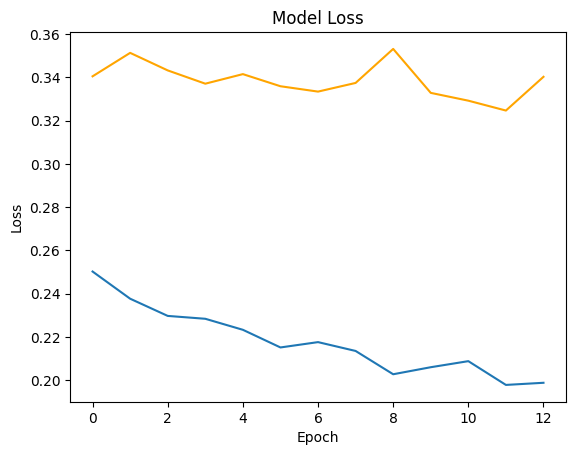

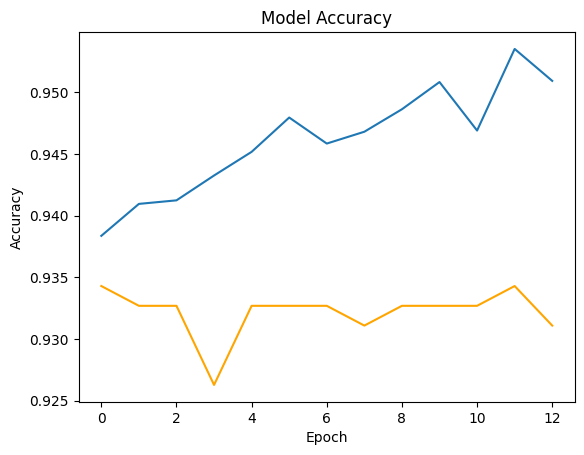

In [11]:
try:
    #loss
    plt.plot(history.history['loss'], label='loss')
    try:
        plt.plot(history.history['val_loss'], label='val_loss', color='orange')
    except (ValueError, NameError):
        print('\033[91mfailed to load val_loss.')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()
    #acc
    plt.plot(history.history['accuracy'], label='accuracy')
    try:
        plt.plot(history.history['val_accuracy'], label='val_accuracy', color='orange')
    except (ValueError, NameError):
        print('\033[91mfailed to load val_accuracy.')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()
except (ValueError, NameError):
    print('\033[91mfailed to load model history.')

## Analyse model Predicting performance

### Gradcam heatmap

#### V2

In [1]:
def compute_heatmap(model, img_array, conv_layer_name, pred_index):
    """
    Helper function to compute the heatmap for a given convolutional layer.
    """
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_layer_output, preds = grad_model(img_array)
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_layer_output = conv_layer_output[0]
    heatmap = conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, second_last_conv_layer_name=None, pred_index=None, threshold=0, sensitivity_map=1.0):
    """
    Function to compute the Grad-CAM heatmap for a specific class, given an input image.
    """
    if pred_index is None:
        preds = model.predict(img_array)
        pred_index = tf.argmax(preds[0])

    # Compute heatmap for the last convolutional layer
    heatmap = compute_heatmap(model, img_array, last_conv_layer_name, pred_index)
    
    # Apply threshold and adjust sensitivity
    heatmap = np.where(heatmap > threshold, heatmap, 0)
    heatmap = heatmap ** sensitivity_map

    if second_last_conv_layer_name is not None:
        # Compute heatmap for the second last convolutional layer
        heatmap_second = compute_heatmap(model, img_array, second_last_conv_layer_name, pred_index)
        
        # Apply threshold and adjust sensitivity
        heatmap_second = np.where(heatmap_second > threshold, heatmap_second, 0)
        heatmap_second = heatmap_second ** sensitivity_map
        
        # Average the two heatmaps
        heatmap = (heatmap + heatmap_second) / 2.0
    
    return heatmap

### Main test

In [2]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.stats import binom
from tqdm import tqdm
import efficientnet.tfkeras
import cv2

Extra_EXT = ''
prob_L = 0.9995
tick_spacing = 5
Train_data_test = False
if SAVE_TYPE == 'TF':
    # Load the pre-trained model
    model = load_model('PAI_model')
else:
    # Load the pre-trained model
    model = load_model(f'PAI_model{Extra_EXT}.h5')

# Ensure the model's input_shape matches your data
assert model.input_shape[1:] == (img_res[0], img_res[1], img_res[2]), 'Models input shape doesnt match data.'

# Make predictions on validation data
val_predictions = model.predict(x_val)
val_predictions = np.argmax(val_predictions, axis=1)

# Make predictions on Train data
if Train_data_test:
    Train_predictions = model.predict(x_train)
    Train_predictions = np.argmax(Train_predictions, axis=1)

# Make predictions on test data
test_predictions = model.predict(x_test)
test_predictions = np.argmax(test_predictions, axis=1)

# Convert y_val and y_test from one-hot encoder to their original form
y_val_original = np.argmax(y_val, axis=1)
y_test_original = np.argmax(y_test, axis=1)
if Train_data_test:
    y_train_original = np.argmax(y_train, axis=1)

# Calculate accuracy on validation data
val_accuracy = accuracy_score(y_val_original, val_predictions)

# Calculate accuracy on Train data
if Train_data_test:
    Train_accuracy = accuracy_score(y_val_original, Train_predictions)

# Calculate accuracy on test data
test_accuracy = accuracy_score(y_test_original, test_predictions)

# Print acc
if Train_data_test:
    print(f'The accuracy of the model on Train data is {Train_accuracy:.2%}')
print(f'The accuracy of the model on validation data is {val_accuracy:.2%}')
print(f'The accuracy of the model on test data is {test_accuracy:.2%}')

# Visualize the predictions on validation data as a grid of squares
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_val[i])
    plt.title(f'True: {y_val_original[i]}\nPredicted: {val_predictions[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()
#Heatmap
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    img = x_val[i]
    heatmap = make_gradcam_heatmap(img[np.newaxis, ...], model, 'top_conv', sensitivity_map = 0.95) 
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    # Apply Adaptive Histogram Equalization
    clahe = cv2.createCLAHE(clipLimit=4, tileGridSize=(4,4))  # Create CLAHE object
    heatmap = clahe.apply(heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.0019 + img
    #clip
    superimposed_img = np.clip(superimposed_img, 0, 1)  # ensure the values are in the range [0, 1]
    plt.imshow(superimposed_img)
    plt.title(f'True: {y_val_original[i]}\nPredicted: {val_predictions[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Define the list of labels
labels = ['NORMAL', 'PNEUMONIA']

# Create a confusion matrix for validation data
val_cm = confusion_matrix(y_val_original, val_predictions)

# Create a confusion matrix for test data
test_cm = confusion_matrix(y_test_original, test_predictions)

# Plot the confusion matrix as a heatmap for validation data
plt.figure(figsize=(8, 6))
sns.heatmap(val_cm, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Validation Data')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot the confusion matrix as a heatmap for test data
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Define the range of test data sizes to use
data_sizes = range(1, len(x_test), 4)  
# Calculate the probability of a wrong prediction based on test accuracy
prob_wrong = 1 - test_accuracy

# Create a list to store the number of incorrect predictions for each test data size
incorrect_predictions = []

# Generate predictions and track incorrect predictions for each data size
for size in tqdm(data_sizes, desc='Predicting', unit='dpb'):
    # Randomly select a subset of test data
    indices = np.random.choice(len(x_test), size, replace=False)
    x_test_subset = x_test[indices]
    y_test_subset = y_test[indices]

    # Make predictions on the subset of test data
    test_predictions = model.predict(x_test_subset, batch_size=1, verbose=0, max_queue_size=120, workers=1, use_multiprocessing=False)
    test_predictions = np.argmax(test_predictions, axis=1)
    y_test_original_subset = np.argmax(y_test_subset, axis=1)

    # Calculate the number of incorrect predictions
    incorrect_preds = np.sum(test_predictions != y_test_original_subset)
    incorrect_predictions.append(incorrect_preds)
    
# Plot the number of incorrect predictions vs. the number of data points
plt.figure(figsize=(10, 6))
plt.plot(data_sizes, incorrect_predictions)
plt.xlabel('Number of Data Points')
plt.ylabel('Number of Incorrect Predictions')
# Add gridlines for the x and y axes
plt.grid(True)

# Change the tick spacing for the x and y axes
plt.xticks(np.arange(min(data_sizes), max(data_sizes)+1, 50))
plt.yticks(np.arange(0, max(incorrect_predictions) + 5, 3))

plt.title('Number of Incorrect Predictions vs. Number of Data Points')
plt.show()

# Define the range of test data sizes to use
data_sizes = range(1, len(x_test), 1) 

# Calculate the probability of a wrong prediction based on test accuracy
prob_wrong = 1 - test_accuracy

# Create a list to store the probability of getting at least one wrong answer for each test data size
probabilities = []

# Calculate the probability of getting at least one wrong answer for each data size
for size in data_sizes:
    # Calculate the cumulative distribution function (CDF) of the binomial distribution at 0
    cdf = binom.cdf(0, size, prob_wrong)
    # Subtract the CDF from 1 to get the probability of getting at least one wrong answer
    prob = 1 - cdf
    probabilities.append(prob)

# Find the index of the first data point that has a probability greater than prob_L%
index = next((i for i, p in enumerate(probabilities) if p > prob_L), len(probabilities))

# Limit the x-axis to the first data point that has a probability greater than prob_L%
data_sizes = data_sizes[:index+1]
probabilities = probabilities[:index+1]

# Plot the probability vs. the number of data points
plt.figure(figsize=(10, 6))
plt.plot(data_sizes, probabilities)
plt.xlabel('Number of Data Points')
plt.ylabel('Probability')

# Add gridlines for the x and y axes
plt.grid(True)

# Change the tick spacing for the x and y axes
plt.xticks(np.arange(min(data_sizes), max(data_sizes)+1, tick_spacing + 2))
plt.yticks(np.arange(0, max(probabilities)+0.1, tick_spacing / 100))

plt.ylim(top=1.01)

plt.title('Probability of Getting at Least One Wrong Answer vs. Number of Data Points')
plt.show()

NameError: name 'SAVE_TYPE' is not defined